In [13]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from tqdm.autonotebook  import tqdm
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [0]:
class MyModel(torch.nn.Module):
      def __init__(self, nb_channel_in, nb_channel_middle, nb_channel_out, kernel_size, kernel_size_pooling, nb_feature_middle, drop_out, nb_class, x_size, y_size):
          super(MyModel, self).__init__()
        
          self.conv1 = torch.nn.Conv2d(nb_channel_in, nb_channel_middle, kernel_size)
          x_size = (x_size-(kernel_size-1))
          y_size = (y_size-(kernel_size-1))
          
          self.pooling1 = torch.nn.MaxPool2d(kernel_size_pooling)
          x_size = x_size//kernel_size_pooling
          y_size = y_size//kernel_size_pooling
          
          self.conv2 = torch.nn.Conv2d(nb_channel_middle, nb_channel_out, kernel_size)
          x_size = (x_size-(kernel_size-1))
          y_size = (y_size-(kernel_size-1))
          
          self.pooling2 = torch.nn.MaxPool2d(kernel_size_pooling)
          x_size = x_size//kernel_size_pooling
          y_size = y_size//kernel_size_pooling
          self.nb_features = (x_size*y_size)*nb_channel_out
          
          self.linear1 = torch.nn.Linear(self.nb_features, nb_feature_middle)
          self.dropout = torch.nn.Dropout(drop_out)
          self.linear2 = torch.nn.Linear(nb_feature_middle, nb_class)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.pooling1(x)
          x = F.relu(self.conv2(x))
          x = self.pooling2(x)
          
          x = x.view(-1, self.nb_features)
          x = F.relu(self.linear1(x))
          x = self.dropout(x)
          x = self.linear2(x)
          return x

In [0]:
def goThoughDataset(loader, my_model, loss, cuda, nb_class, nb_channel, x_size, y_size, train=False, valid=False, nb_error_to_get=None):
  
  #init track
  running_loss = 0
  confusion_matrix_golden_pred = torch.zeros(nb_class, nb_class).long()
  confusion_matrix_golden_pred_picture = None
  if nb_error_to_get != None:
    confusion_matrix_golden_pred_picture = torch.zeros(nb_class, nb_class, nb_error_to_get, nb_channel, x_size, y_size)
  if cuda:
    confusion_matrix_golden_pred = confusion_matrix_golden_pred.cuda()
    if nb_error_to_get != None:
      confusion_matrix_golden_pred_picture = confusion_matrix_golden_pred_picture.cuda()
  
  if train:
    loader = tqdm(loader)
    my_model.train(True)
    torch.set_grad_enabled(True)
  else:
    my_model.eval()
    torch.set_grad_enabled(False)
    
  for x, y in loader:
    
    x = Variable(x)
    
    #put tensor on the GPU
    if cuda:
      x = x.cuda(non_blocking=True)
      y = y.cuda(non_blocking=True)

    #forward
    y_pred_proba = my_model(x)
    l = loss(y_pred_proba, y)
    
    #train on the batch
    if train:
      l.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
    
    #keep track of the confusion for each class
    _, y_pred = y_pred_proba.max(1)
    for i in range(0, nb_class):
      for j in range(0, nb_class):
        mask_confusion = (y_pred==j)&(y==i)
        old_nb_of_confusion = confusion_matrix_golden_pred[i][j]
        nb_of_new_confusion = mask_confusion.sum()
        if nb_error_to_get != None and old_nb_of_confusion < nb_error_to_get:
          indice_confusion = torch.arange(0, mask_confusion.size(0))[mask_confusion].long()
          if cuda:
            indice_confusion = indice_confusion.cuda()
          indice_confusion_cap = indice_confusion[:min(nb_of_new_confusion, nb_error_to_get-old_nb_of_confusion)]
          confusion_matrix_golden_pred_picture[i][j][old_nb_of_confusion:min(old_nb_of_confusion+nb_of_new_confusion, nb_error_to_get)] = x.index_select(0, indice_confusion_cap)
        confusion_matrix_golden_pred[i][j] += nb_of_new_confusion

    #keep track of the loss
    running_loss += l.sum()
    
  if valid:
    scheduler.step(running_loss)

  return running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, my_model

def printStat(running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, nb_entries, step, cuda, plot_confusion=False):
  nb_class = len(confusion_matrix_golden_pred)
  
  #compute stats from confusion matrix
  accuracy = 0.
  list_precision = []
  list_recall = []
  confusion_matrix_img = confusion_matrix_golden_pred.clone()
  for i in range(0, nb_class):
    accuracy += float(confusion_matrix_golden_pred[i][i])
    list_precision.append(float(confusion_matrix_golden_pred[i][i]) / float(confusion_matrix_golden_pred[:,i].sum()))
    list_recall.append(float(confusion_matrix_golden_pred[i][i]) / float(confusion_matrix_golden_pred[i,:].sum()))
    confusion_matrix_img[i][i] = 0 #to better see the errors
  accuracy = (accuracy * 100) / nb_entries
 
  #plot stats
  print(step+" loss : "+str("%.2f" % (running_loss/nb_entries)))
  print(step+" accuracy : "+str("%.2f" % accuracy))
  print(step+" precision : "+str(["%.2f" % (list_precision[i]*100) for i in range(0, len(list_precision))]))
  print(step+" recall : "+str(["%.2f" % (list_recall[i]*100) for i in range(0, len(list_recall))]))
  print(step+" confusion matrix : ")
  if cuda:
    confusion_matrix_img = confusion_matrix_img.cpu()
  img  = plt.imshow(confusion_matrix_img, cmap='hot')
  plt.colorbar(img)
  plt.show()
  
  #plot confusions
  if plot_confusion:
    print(step+" few confusions : ")
    if cuda:
      confusion_matrix_golden_pred_picture = confusion_matrix_golden_pred_picture.cpu()
    f, list_ax = plt.subplots(nb_class,nb_class)
    for i in range(0, nb_class):
      for j in range(0, nb_class):
        if i != j and confusion_matrix_golden_pred[i][j] != 0:
          list_ax[i][j].imshow(confusion_matrix_golden_pred_picture[i][j][0][0])
        list_ax[i][j].axis('off')
        if i == 0:
          list_ax[i][j].set_xlabel(j)
        if j == 0:
          list_ax[i][j].set_ylabel(i)
    plt.show()
        
  return accuracy, list_precision, list_recall

MyModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3200, out_features=512, bias=True)
  (dropout): Dropout(p=0.5)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

_____ Epoch 1 _____


Train loss : 0.81
Train accuracy : 76.46
Train precision : ['76.90', '81.85', '72.60', '76.81', '75.49', '79.76', '73.96', '81.15', '72.47', '72.85']
Train recall : ['89.94', '89.14', '77.80', '72.84', '76.04', '63.79', '84.04', '77.96', '64.70', '65.29']
Train confusion matrix : 


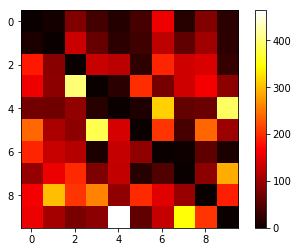

Validation loss : 0.21
Validation accuracy : 94.16
Validation precision : ['98.00', '94.18', '96.12', '95.45', '95.11', '92.37', '98.44', '92.79', '96.27', '84.85']
Validation recall : ['97.16', '98.37', '92.15', '91.83', '93.84', '96.68', '96.02', '95.05', '86.05', '93.79']
Validation confusion matrix : 


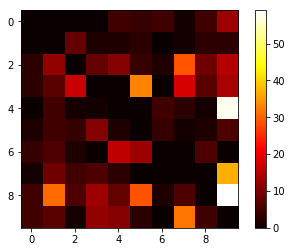


_____ Epoch 2 _____


Train loss : 0.29
Train accuracy : 91.62
Train precision : ['93.70', '94.38', '91.10', '91.42', '91.96', '91.57', '93.16', '91.33', '89.28', '87.73']
Train recall : ['94.92', '96.57', '90.03', '90.34', '91.94', '91.87', '94.30', '91.22', '87.12', '87.28']
Train confusion matrix : 


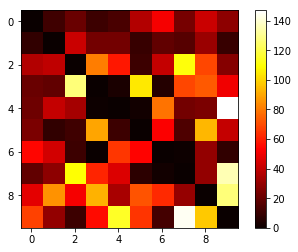

Validation loss : 0.12
Validation accuracy : 96.63
Validation precision : ['98.53', '98.36', '97.84', '96.25', '97.48', '96.55', '97.82', '95.66', '94.35', '93.48']
Validation recall : ['98.19', '97.70', '95.44', '95.30', '96.50', '98.03', '98.56', '96.43', '95.26', '94.93']
Validation confusion matrix : 


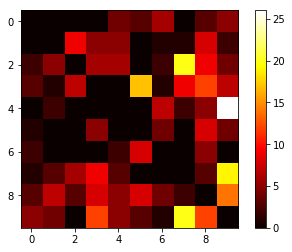


_____ Epoch 3 _____


Train loss : 0.20
Train accuracy : 94.21
Train precision : ['95.76', '96.26', '94.03', '93.95', '94.31', '93.87', '95.72', '93.65', '92.14', '92.01']
Train recall : ['96.72', '97.35', '93.00', '92.78', '94.61', '93.94', '96.24', '94.04', '91.59', '91.37']
Train confusion matrix : 


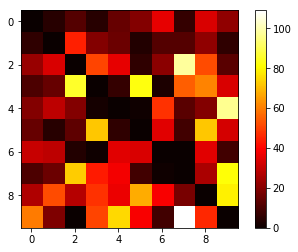

Validation loss : 0.09
Validation accuracy : 97.28
Validation precision : ['99.21', '99.02', '97.38', '96.72', '98.23', '97.50', '98.40', '97.70', '95.48', '93.32']
Validation recall : ['97.25', '97.70', '97.21', '97.28', '97.00', '98.12', '98.65', '96.27', '96.40', '96.98']
Validation confusion matrix : 


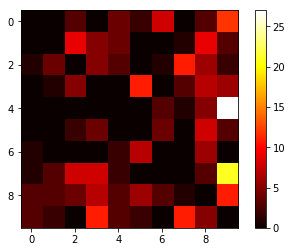


_____ Epoch 4 _____


Train loss : 0.15
Train accuracy : 95.36
Train precision : ['96.57', '97.09', '94.76', '95.15', '96.05', '95.46', '96.55', '94.96', '93.64', '93.12']
Train recall : ['97.12', '97.76', '95.08', '94.17', '95.97', '95.17', '96.81', '95.19', '93.19', '92.85']
Train confusion matrix : 


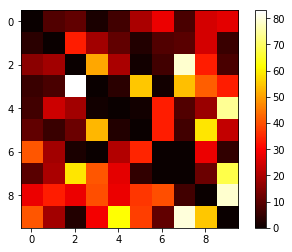

Validation loss : 0.07
Validation accuracy : 97.78
Validation precision : ['98.71', '98.74', '97.62', '98.00', '98.99', '97.76', '98.82', '96.89', '95.70', '96.55']
Validation recall : ['98.54', '98.59', '97.04', '96.86', '97.67', '98.03', '98.98', '98.46', '97.54', '96.08']
Validation confusion matrix : 


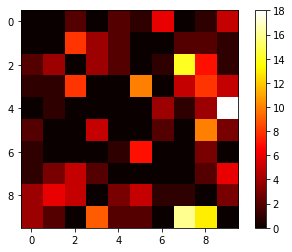


_____ Epoch 5 _____


Train loss : 0.13
Train accuracy : 96.10
Train precision : ['96.74', '97.67', '95.01', '96.25', '96.41', '95.94', '96.80', '95.77', '95.29', '94.90']
Train recall : ['97.23', '98.13', '95.66', '95.06', '96.16', '96.14', '97.19', '96.22', '94.40', '94.56']
Train confusion matrix : 


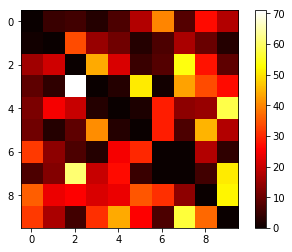

Validation loss : 0.06
Validation accuracy : 98.13
Validation precision : ['98.54', '98.74', '98.21', '98.25', '98.91', '98.21', '98.82', '97.29', '98.21', '96.21']
Validation recall : ['98.80', '98.89', '97.38', '97.52', '98.00', '98.39', '99.49', '98.86', '96.49', '97.39']
Validation confusion matrix : 


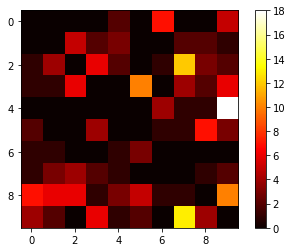


_____ Epoch 6 _____


Train loss : 0.12
Train accuracy : 96.54
Train precision : ['97.15', '98.04', '95.72', '96.93', '97.42', '96.35', '97.19', '96.11', '95.40', '94.90']
Train recall : ['97.92', '98.39', '96.06', '95.79', '96.83', '96.31', '97.26', '96.26', '95.08', '95.28']
Train confusion matrix : 


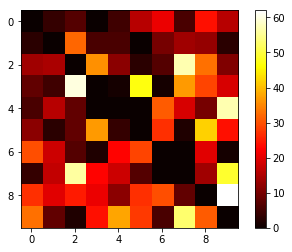

Validation loss : 0.06
Validation accuracy : 98.40
Validation precision : ['99.22', '99.33', '98.30', '98.27', '98.75', '98.74', '98.82', '97.44', '97.72', '97.38']
Validation recall : ['98.54', '98.66', '97.89', '98.51', '98.67', '98.65', '99.24', '98.70', '97.89', '97.22']
Validation confusion matrix : 


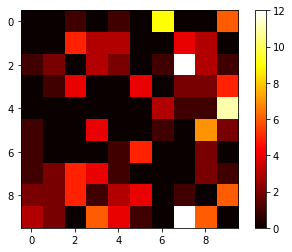


_____ Epoch 7 _____


Train loss : 0.10
Train accuracy : 96.91
Train precision : ['97.33', '98.10', '96.45', '97.14', '97.09', '96.91', '97.80', '96.10', '96.41', '95.64']
Train recall : ['98.19', '98.61', '96.29', '95.93', '97.03', '96.77', '97.78', '96.88', '95.80', '95.60']
Train confusion matrix : 


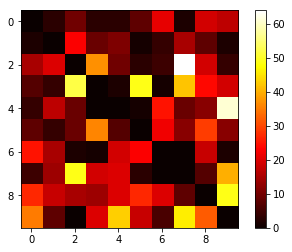

Validation loss : 0.05
Validation accuracy : 98.38
Validation precision : ['99.39', '99.26', '98.56', '98.92', '99.08', '98.74', '98.41', '97.98', '97.05', '96.38']
Validation recall : ['98.02', '99.11', '98.14', '97.94', '98.17', '98.74', '99.49', '98.22', '97.98', '97.88']
Validation confusion matrix : 


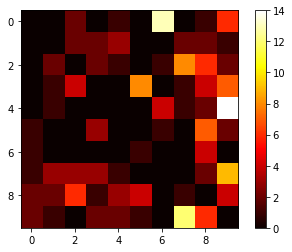


_____ Epoch 8 _____


Train loss : 0.09
Train accuracy : 97.26
Train precision : ['97.78', '98.52', '96.61', '97.36', '97.75', '96.95', '97.71', '97.15', '96.49', '96.04']
Train recall : ['98.26', '98.78', '97.36', '96.54', '97.37', '96.82', '98.10', '97.48', '95.67', '95.94']
Train confusion matrix : 


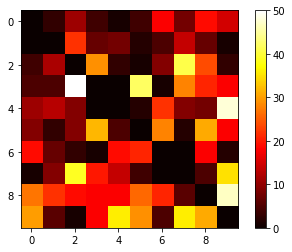

Validation loss : 0.05
Validation accuracy : 98.59
Validation precision : ['99.22', '99.26', '99.23', '98.68', '99.24', '99.46', '98.66', '97.91', '97.32', '97.02']
Validation recall : ['98.62', '99.11', '97.38', '98.76', '98.33', '98.21', '99.49', '98.78', '98.60', '98.53']
Validation confusion matrix : 


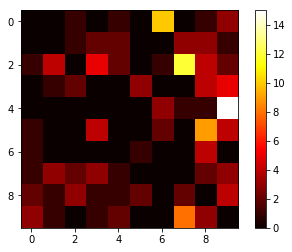


_____ Epoch 9 _____


Train loss : 0.09
Train accuracy : 97.38
Train precision : ['98.11', '98.45', '96.67', '97.82', '97.50', '97.33', '97.85', '96.70', '96.81', '96.41']
Train recall : ['98.32', '98.63', '96.67', '96.85', '97.31', '97.21', '98.16', '97.34', '96.54', '96.57']
Train confusion matrix : 


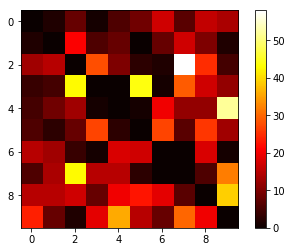

Validation loss : 0.04
Validation accuracy : 98.75
Validation precision : ['99.39', '99.04', '98.81', '99.17', '99.00', '98.40', '99.32', '97.92', '98.16', '98.27']
Validation recall : ['98.88', '99.48', '98.31', '98.10', '99.08', '99.01', '99.58', '99.19', '98.16', '97.63']
Validation confusion matrix : 


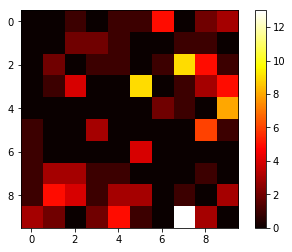


_____ Epoch 10 _____


Train loss : 0.08
Train accuracy : 97.62
Train precision : ['98.30', '98.56', '97.28', '97.73', '97.80', '97.44', '98.29', '97.09', '96.90', '96.65']
Train recall : ['98.63', '98.85', '97.24', '97.01', '97.67', '97.10', '98.50', '97.56', '96.88', '96.53']
Train confusion matrix : 


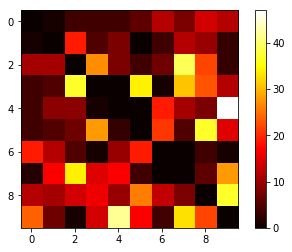

Validation loss : 0.04
Validation accuracy : 98.83
Validation precision : ['99.31', '99.48', '99.07', '99.25', '99.33', '99.19', '98.99', '98.39', '97.74', '97.57']
Validation recall : ['98.71', '99.26', '98.48', '98.60', '98.50', '99.10', '99.75', '98.86', '98.60', '98.45']
Validation confusion matrix : 


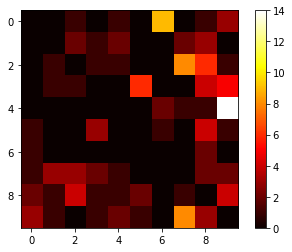


_____ Epoch 11 _____


Train loss : 0.08
Train accuracy : 97.79
Train precision : ['98.39', '98.74', '97.18', '98.01', '97.91', '97.45', '98.50', '97.24', '97.20', '97.15']
Train recall : ['98.61', '98.98', '97.47', '97.05', '98.04', '97.54', '98.67', '97.44', '97.26', '96.72']
Train confusion matrix : 


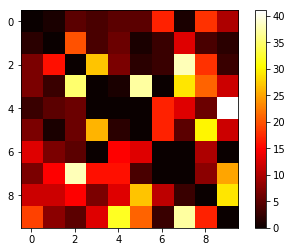

Validation loss : 0.04
Validation accuracy : 98.88
Validation precision : ['99.56', '99.55', '99.15', '98.93', '99.58', '99.10', '99.16', '98.15', '98.50', '97.19']
Validation recall : ['98.45', '99.33', '98.14', '99.26', '98.92', '99.19', '99.41', '99.03', '98.07', '98.94']
Validation confusion matrix : 


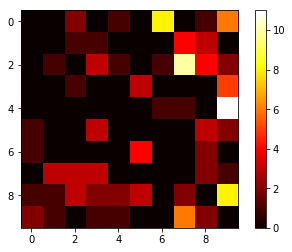


_____ Epoch 12 _____


Train loss : 0.07
Train accuracy : 97.79
Train precision : ['98.43', '98.94', '96.97', '97.77', '97.95', '97.97', '98.27', '97.17', '97.03', '97.29']
Train recall : ['98.63', '98.98', '97.15', '97.32', '97.89', '97.49', '98.59', '97.67', '96.92', '97.08']
Train confusion matrix : 


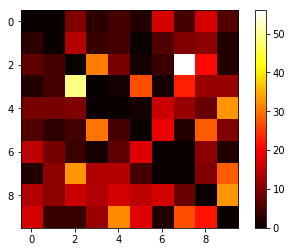

Validation loss : 0.04
Validation accuracy : 98.83
Validation precision : ['99.74', '99.48', '99.23', '98.76', '99.41', '99.02', '98.66', '97.92', '98.34', '97.81']
Validation recall : ['97.68', '99.18', '97.97', '98.84', '98.92', '99.46', '99.66', '99.19', '98.86', '98.53']
Validation confusion matrix : 


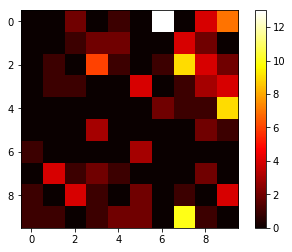


_____ Epoch 13 _____


Train loss : 0.07
Train accuracy : 98.00
Train precision : ['98.47', '98.85', '97.65', '97.94', '98.29', '97.77', '98.30', '97.47', '97.85', '97.33']
Train recall : ['98.80', '99.00', '97.49', '97.44', '97.89', '97.70', '98.69', '98.07', '97.41', '97.38']
Train confusion matrix : 


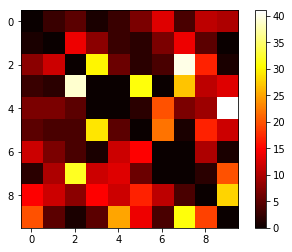

Validation loss : 0.04
Validation accuracy : 98.72
Validation precision : ['99.48', '99.48', '99.31', '98.60', '99.58', '99.02', '98.91', '97.99', '97.58', '97.34']
Validation recall : ['98.28', '99.18', '97.38', '98.51', '98.33', '99.28', '99.66', '98.86', '99.21', '98.53']
Validation confusion matrix : 


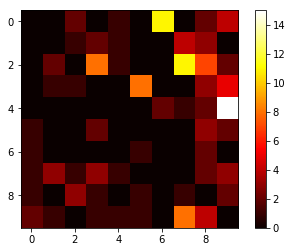


_____ Epoch 14 _____


Train loss : 0.06
Train accuracy : 98.03
Train precision : ['98.51', '98.96', '97.49', '98.16', '98.09', '97.77', '98.44', '97.66', '97.57', '97.45']
Train recall : ['98.91', '99.04', '97.63', '97.38', '98.25', '97.75', '98.65', '97.91', '97.37', '97.23']
Train confusion matrix : 


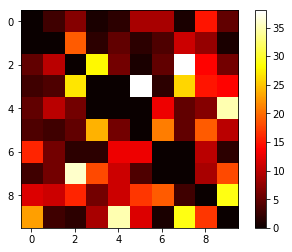

Validation loss : 0.03
Validation accuracy : 98.92
Validation precision : ['99.48', '99.41', '98.99', '99.25', '99.58', '98.93', '98.91', '98.54', '98.43', '97.65']
Validation recall : ['98.62', '99.41', '98.90', '98.76', '98.33', '99.37', '99.58', '98.86', '98.68', '98.61']
Validation confusion matrix : 


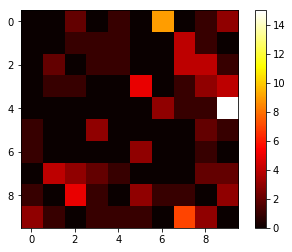


_____ Epoch 15 _____


Train loss : 0.06
Train accuracy : 98.10
Train precision : ['98.45', '98.98', '97.48', '98.28', '98.36', '97.89', '98.23', '97.72', '98.10', '97.44']
Train recall : ['98.87', '99.04', '97.91', '97.62', '98.19', '97.98', '98.59', '98.03', '97.37', '97.33']
Train confusion matrix : 


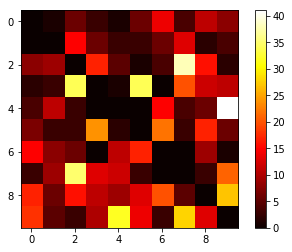

Validation loss : 0.03
Validation accuracy : 98.92
Validation precision : ['99.48', '99.63', '99.15', '99.34', '99.50', '99.28', '99.41', '98.71', '96.50', '98.13']
Validation recall : ['99.05', '99.11', '98.65', '98.84', '98.67', '98.83', '99.41', '98.95', '99.21', '98.45']
Validation confusion matrix : 


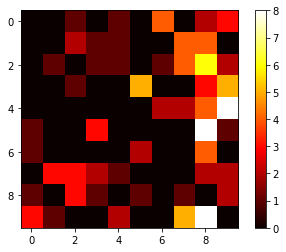


_____ Epoch 16 _____


Train loss : 0.06
Train accuracy : 98.17
Train precision : ['98.83', '99.06', '97.62', '98.45', '98.23', '97.91', '98.48', '97.80', '97.75', '97.43']
Train recall : ['98.97', '99.18', '98.01', '97.82', '98.15', '97.96', '98.61', '97.87', '97.73', '97.25']
Train confusion matrix : 


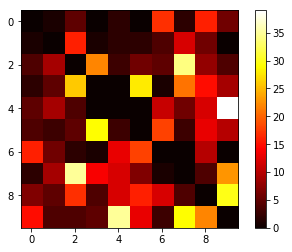

Validation loss : 0.04
Validation accuracy : 98.91
Validation precision : ['99.48', '99.48', '99.32', '99.09', '99.66', '99.64', '98.66', '98.47', '98.00', '97.35']
Validation recall : ['98.45', '99.33', '98.48', '99.26', '98.25', '98.57', '99.66', '98.95', '98.95', '99.10']
Validation confusion matrix : 


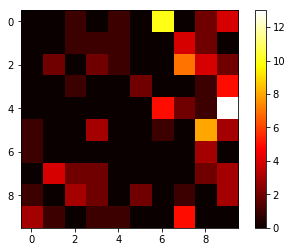


_____ Epoch 17 _____


Train loss : 0.06
Train accuracy : 98.30
Train precision : ['98.72', '99.13', '97.93', '98.61', '98.47', '98.14', '98.46', '97.96', '97.85', '97.58']
Train recall : ['99.12', '99.24', '97.97', '98.07', '98.30', '98.07', '98.78', '98.37', '97.64', '97.27']
Train confusion matrix : 


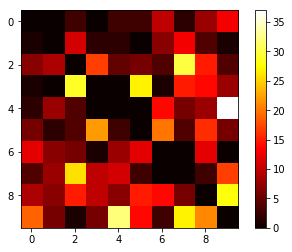

Validation loss : 0.03
Validation accuracy : 99.03
Validation precision : ['99.57', '99.55', '99.49', '99.09', '99.25', '99.64', '99.41', '98.63', '97.00', '98.69']
Validation recall : ['99.14', '99.33', '98.48', '99.09', '99.17', '99.10', '99.32', '99.11', '99.39', '98.20']
Validation confusion matrix : 


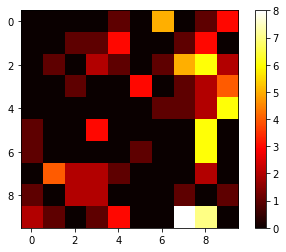


_____ Epoch 18 _____


Train loss : 0.05
Train accuracy : 98.37
Train precision : ['98.85', '98.98', '97.87', '98.73', '98.60', '97.96', '98.78', '97.96', '98.10', '97.73']
Train recall : ['98.99', '99.15', '98.05', '97.87', '98.53', '98.17', '98.88', '98.45', '97.79', '97.67']
Train confusion matrix : 


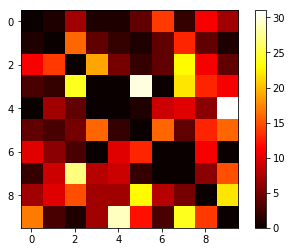

Validation loss : 0.03
Validation accuracy : 99.11
Validation precision : ['99.65', '99.55', '99.24', '99.18', '99.33', '99.64', '99.16', '98.79', '98.60', '97.98']
Validation recall : ['98.71', '99.48', '98.65', '99.26', '99.08', '98.92', '99.83', '99.03', '99.04', '99.02']
Validation confusion matrix : 


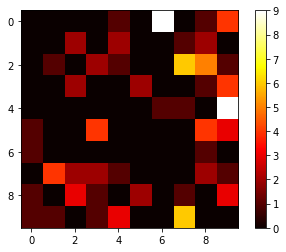


_____ Epoch 19 _____


Train loss : 0.05
Train accuracy : 98.46
Train precision : ['98.91', '99.13', '98.41', '98.59', '98.49', '98.17', '98.51', '98.14', '98.06', '98.09']
Train recall : ['99.12', '99.22', '98.26', '98.23', '98.32', '98.33', '98.86', '98.61', '97.81', '97.71']
Train confusion matrix : 


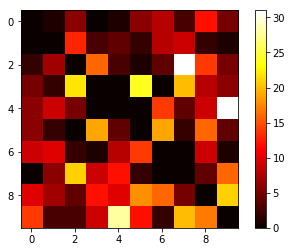

Validation loss : 0.03
Validation accuracy : 99.22
Validation precision : ['99.57', '99.56', '99.41', '99.26', '99.75', '99.73', '99.24', '99.03', '98.60', '98.14']
Validation recall : ['98.97', '99.78', '98.90', '99.26', '98.83', '99.10', '99.83', '99.19', '99.12', '99.18']
Validation confusion matrix : 


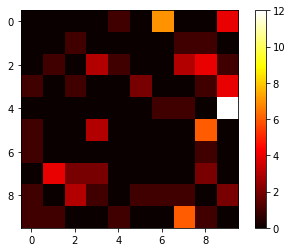


_____ Epoch 20 _____


Train loss : 0.05
Train accuracy : 98.48
Train precision : ['98.87', '99.19', '98.26', '98.57', '98.60', '98.21', '98.72', '98.04', '98.26', '98.03']
Train recall : ['99.14', '99.30', '98.01', '98.35', '98.36', '98.24', '99.07', '98.49', '98.03', '97.71']
Train confusion matrix : 


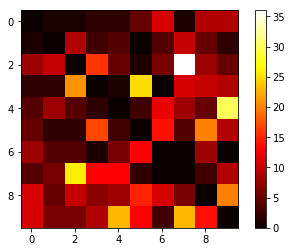

Validation loss : 0.03
Validation accuracy : 99.17
Validation precision : ['99.57', '99.48', '99.57', '98.77', '99.66', '99.82', '99.24', '98.47', '99.21', '97.98']
Validation recall : ['98.88', '99.41', '98.48', '99.67', '98.92', '99.10', '99.75', '99.19', '99.12', '99.10']
Validation confusion matrix : 


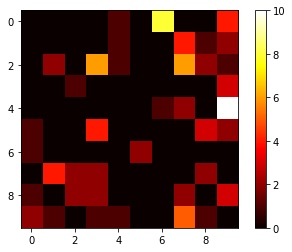


_____ Synthesis _____
Best validation loss : 0.03
Best validation accuracy : 99.22
Best validation precision : ['99.57', '99.56', '99.41', '99.26', '99.75', '99.73', '99.24', '99.03', '98.60', '98.14']
Best validation recall : ['98.97', '99.78', '98.90', '99.26', '98.83', '99.10', '99.83', '99.19', '99.12', '99.18']
Best validation confusion matrix : 


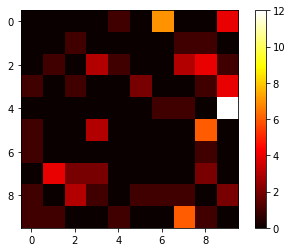

Best validation few confusions : 


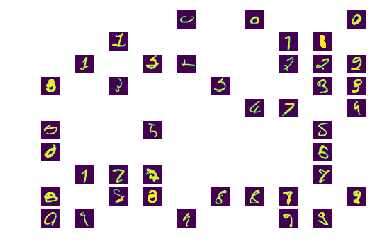

Test loss : 0.02
Test accuracy : 99.18
Test precision : ['99.69', '99.82', '99.51', '98.05', '99.49', '98.55', '99.47', '98.65', '99.38', '99.11']
Test recall : ['99.39', '99.65', '98.64', '99.70', '99.59', '98.77', '98.64', '99.22', '99.18', '98.91']
Test confusion matrix : 


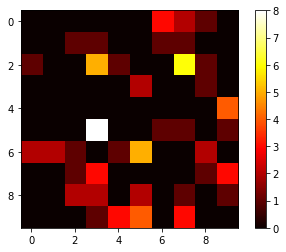

In [17]:
#parameters
params = {
  "rotation": 5,
  "batch_size": 128,
  "nb_epoch": 20,
  "nb_channel_middle": 64,
  "nb_channel_out": 128,
  "kernel_size": 3,
  "kernel_size_pooling": 2,
  "nb_feature_middle": 512,
  "drop_out": 0.5,
  "validation_split": 0.2,
  "lr": 1e-4,
  "momentum": 0.5,
  "cuda": True}

#save params
filename = "mnist_params.pt"
torch.save(params, filename)
files.download(filename)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop((28, 28), scale=(0.8, 1)),
    transforms.RandomRotation(params["rotation"]),
    transforms.ToTensor(), #to go from PIL images to torch tensors
])
transform_valid = transforms.Compose([
    transforms.ToTensor(), #to go from PIL images to torch tensors
])
transform_test = transforms.Compose([
    transforms.ToTensor(), #to go from PIL images to torch tensors
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_validset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_valid)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

#split train dataset to train and validation
dataset_size = len(mnist_trainset)
indices = list(range(dataset_size))
split = int(params["validation_split"] * dataset_size)
np.random.shuffle(indices)
train_indices, validation_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

#defined by the dataset
nb_channel = 1 
nb_class = 10
x_size = 28
y_size = 28
nb_train_entries = dataset_size-split
nb_validation_entries = split
nb_test_entries = len(mnist_testset)

train_loader = DataLoader(mnist_trainset, batch_size=params["batch_size"], pin_memory=params["cuda"], sampler=train_sampler)
validation_loader = DataLoader(mnist_validset, batch_size=params["batch_size"], pin_memory=params["cuda"], sampler=validation_sampler)
test_loader = DataLoader(mnist_testset, batch_size=params["batch_size"], pin_memory=params["cuda"])

my_model = MyModel(nb_channel, params["nb_channel_middle"], params["nb_channel_out"], params["kernel_size"], params["kernel_size_pooling"], params["nb_feature_middle"], params["drop_out"], nb_class, x_size, y_size)
if params["cuda"]:
  my_model = my_model.cuda()
print(my_model)
  
loss = torch.nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.Adam(my_model.parameters(), lr=params["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

best_model = my_model
best_acc = 0
best_loss = None
best_confusion_matrix_golden_pred = None
best_confusion_matrix_golden_pred_picture = None
for epoch in range(0, params["nb_epoch"]):
    print("\n_____ Epoch "+str(epoch+1)+" _____")
    #train
    running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, my_model = goThoughDataset(train_loader, my_model, loss, params["cuda"], nb_class, nb_channel, x_size, y_size, train=True, valid=False)
    printStat(running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, nb_train_entries, "Train", params["cuda"])
    
    #validation
    running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, _ = goThoughDataset(validation_loader, my_model, loss, params["cuda"], nb_class, nb_channel, x_size, y_size, train=False, valid=True, nb_error_to_get=1)
    accuracy, _, _ = printStat(running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, nb_validation_entries, "Validation", params["cuda"])
    if best_acc is None or accuracy > best_acc:
      best_acc = accuracy
      best_loss = running_loss
      best_confusion_matrix_golden_pred = confusion_matrix_golden_pred
      best_confusion_matrix_golden_pred_picture = confusion_matrix_golden_pred_picture
      best_model = my_model
  
print("\n_____ Synthesis _____")
#best validation
_, list_precision, list_recall = printStat(best_loss, best_confusion_matrix_golden_pred, best_confusion_matrix_golden_pred_picture, nb_validation_entries, "Best validation", params["cuda"], plot_confusion=True)


#test
running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, _ = goThoughDataset(test_loader, best_model, loss, params["cuda"], nb_class, nb_channel, x_size, y_size, train=False, valid=False)
printStat(running_loss, confusion_matrix_golden_pred, confusion_matrix_golden_pred_picture, nb_test_entries, "Test", params["cuda"])

filename = "mnist_model.pt"
torch.save(best_model.state_dict(), filename)
files.download(filename)